In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import plotly.graph_objects as go

In [470]:
df = pd.read_csv('query_result_2021-06-11T18_18_08.33847Z.csv')
# remove the flights where no tickets were solved
df.dropna(inplace=True)

In [472]:
df.actual_arrival = pd.to_datetime(df.actual_arrival)
df.actual_departure = pd.to_datetime(df.actual_departure)

In [473]:
df['flight_duration'] = (df.actual_arrival - df.actual_departure).apply(lambda x: x.total_seconds() / 60 ** 2)

Данные о цене топлива по месяцам взяты на сайте [ФЕДЕРАЛЬНОЕ АГЕНТСТВО ВОЗДУШНОГО ТРАНСПОРТА](https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/?id=7329).

In [474]:
fuel_kg_per_hour = {
    'Boeing 737-300': 2400,
    'Sukhoi Superjet-100': 1700
}
fuel_price_per_month_Anapa = {
    1: 41.435,
    2: 39.553,
    12: 47.101
}
# НДС - 18% в 2017 году
df['fuel_kg_per_hour'] = df.model.map(fuel_kg_per_hour)
df['fuel_spent'] = df.flight_duration * df.fuel_kg_per_hour
df['fuel_price_per_month_Anapa'] = df.actual_arrival.dt.month.map(fuel_price_per_month_Anapa)
df['fuel_cost'] = df.fuel_spent * (df.fuel_price_per_month_Anapa * 1.18)

Составим сравнительную таблицу по перелетам в двух направлениях.

In [530]:
grouped_by_city = data_for_analysis.groupby(['city', 'model'], as_index=False).agg(
    {
        'flight_id': 'count',
        'flight_duration': 'mean',
        'seats_count_mean': 'mean',
        'profit': 'mean',
        'flight_occupancy': 'mean'
    })
grouped_by_city.profit = grouped_by_city.profit.astype('int64') 
grouped_by_city

,city,model,flight_id,flight_duration,seats_count_mean,profit,flight_occupancy
0,Belgorod,Sukhoi Superjet-100,59,0.834746,97,642547,0.929757
1,Moscow,Boeing 737-300,59,1.663842,130,1451548,0.870143


In [560]:
data = df.groupby(['flight_id', 'city', 'city.1', 'model'], as_index=False).agg({
                                   'longitude': 'mean', 
                                   'latitude': 'mean', 
                                   'longitude.1': 'mean',
                                   'latitude.1': 'mean',
                                   'flight_duration': 'mean'
})

In [578]:
fig = go.Figure()

fig.add_trace(
    go.Scattergeo(
        lat = [data['latitude.1'][0]],
        lon = [data['longitude.1'][0]],
        mode = "text",
        text=f"{data['city.1'][0]}",
        showlegend=False
    )
)

colors=['orange', 'purple']

for city in data.city.unique():
    fig.add_trace(
        go.Scattergeo(
            lat = [data.loc[data.city == city, 'latitude'].values[0]],
            lon = [data.loc[data.city == city, 'longitude'].values[0]],
            mode = "text",
            text=city,
            showlegend=False,  
        )
    )

    opacity = data.loc[data.city == city, :].shape[0] / data.shape[0]
    if city == 'Moscow':
        col = colors[0]
    else:
        col = colors[1]
    fig.add_trace(
        go.Scattergeo(
            lat = [data.loc[data.city == city, 'latitude.1'].values[0], data.loc[data.city == city, 'latitude'].values[0]],
            lon = [data.loc[data.city == city, 'longitude.1'].values[0], data.loc[data.city == city, 'longitude'].values[0]],
            mode = "lines",
            opacity=opacity,
            line = dict(width = 2, color=col),
            name=f"Аnapa - {city} ({round(data.loc[data.city == city, 'flight_duration'].mean(), 1)} ч)"
        )
    )

fig.update_layout(
    showlegend = True,
    geo = go.layout.Geo(
        scope = 'europe',
        projection_type = 'natural earth',
        showland = True,
        showcountries=True,
        showrivers=True,
        showlakes=True,
        lakecolor='lightblue',
        rivercolor='lightblue',
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    title=dict(
            text="Карта полетов из Анапы за зимний период 2017 года",
            font=dict(
                size=16,
            ),
            y=0.92,
            x=0.5,
            xanchor='center',
            yanchor='top'
        ),
)
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

Сгрупируем данные для последующего анализа.

In [478]:
data_for_analysis = df.groupby(
    ['flight_id', 'city', 'city.1', 'longitude', 'latitude', 'longitude.1', 'latitude.1', 'flight_duration', 'model',
    'fuel_cost'],
    as_index=False)\
.agg({'amount':['sum', 'count'], 'seats_count': 'mean'})

In [479]:
data_for_analysis.columns = list(map('_'.join, data_for_analysis.columns.values))
data_for_analysis.columns = [col[:-1] if col[-1] == '_' else col for col in data_for_analysis.columns.values]

Найдем заполняемость самолета и прибыль от полета как разницу между суммой денег от продажи билетов и стоимостью расхода топлива (кг) за час.

In [480]:
data_for_analysis['flight_occupancy'] = data_for_analysis.amount_count / data_for_analysis.seats_count_mean
data_for_analysis['profit'] = data_for_analysis.amount_sum - data_for_analysis.fuel_cost
data_for_analysis.profit = data_for_analysis.profit.astype('int64') 
data_for_analysis.sort_values('profit', inplace=True)

In [592]:
data_for_analysis

,flight_id,city,city.1,longitude,latitude,longitude.1,latitude.1,flight_duration,model,fuel_cost,amount_sum,amount_count,seats_count_mean,flight_occupancy,profit
68,136642,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.816667,Sukhoi Superjet-100,67880.198167,531000.0,64,97,0.659794,463119
93,136807,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.833333,Sukhoi Superjet-100,66119.431667,531000.0,68,97,0.701031,464880
100,136844,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.833333,Sukhoi Superjet-100,66119.431667,575100.0,79,97,0.814433,508980
107,136887,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.816667,Sukhoi Superjet-100,67880.198167,595200.0,78,97,0.804124,527319
111,136922,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.833333,Sukhoi Superjet-100,66119.431667,607800.0,76,97,0.783505,541680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,136423,Moscow,Anapa,37.414600,55.972599,37.347301,45.002102,1.666667,Boeing 737-300,195573.200000,1849400.0,129,130,0.992308,1653826
42,136389,Moscow,Anapa,37.414600,55.972599,37.347301,45.002102,1.666667,Boeing 737-300,195573.200000,1873800.0,129,130,0.992308,1678226
43,136403,Moscow,Anapa,37.414600,55.972599,37.347301,45.002102,1.666667,Boeing 737-300,186690.160000,1873800.0,129,130,0.992308,1687109
19,136226,Moscow,Anapa,37.414600,55.972599,37.347301,45.002102,1.666667,Boeing 737-300,195573.200000,1886000.0,130,130,1.000000,1690426


In [ ]:
sns.histplot()

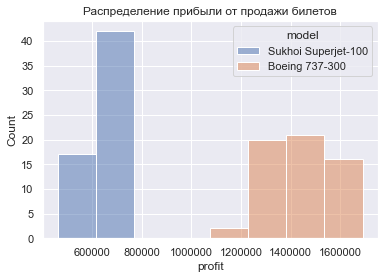

In [607]:
sns.histplot(data=data_for_analysis, x='profit', hue='model')
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Распределение прибыли от продажи билетов');
# plt.savefig('Распределение прибыли от продажи билетов.png');

На данном графике мы отчетливо видим разрыв в распределении данных по доходу от перелетов. Однако, т.к. в этом случае мы анализируем данные от двух разных моделей самолетов, то чтобы делать какие-то выводы дальше, нам нужно проанализировать рейсы на заполняемость салона.

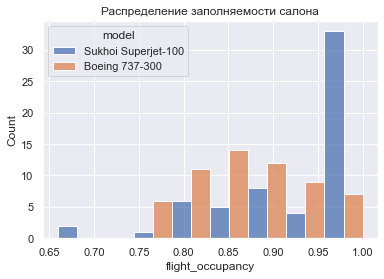

In [639]:
# data_for_analysis.flight_occupancy.value_counts(bins=7).sort_index()
sns.histplot(data=data_for_analysis, x='flight_occupancy', hue='model', multiple="dodge")
plt.title('Распределение заполняемости салона');
# plt.savefig('Распределение заполняемости салона.png');

На графике распределения заполняемости салона для малоприбыльных рейсов мы видим, что она в большинстве случаев превышает 75%. Поэтому отфильтруем полеты, заполняемость самолета в которых меньше 75%.

In [702]:
threshold_occupancy = 0.75
low_occupancy_flights = data_for_analysis[data_for_analysis.flight_occupancy < threshold_occupancy]
low_occupancy_flights

,flight_id,city,city.1,longitude,latitude,longitude.1,latitude.1,flight_duration,model,fuel_cost,amount_sum,amount_count,seats_count_mean,flight_occupancy,profit
68,136642,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.816667,Sukhoi Superjet-100,67880.198167,531000.0,64,97,0.659794,463119
93,136807,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.833333,Sukhoi Superjet-100,66119.431667,531000.0,68,97,0.701031,464880
2,136122,Moscow,Anapa,37.414600,55.972599,37.347301,45.002102,1.666667,Boeing 737-300,195573.200000,1431000.0,97,130,0.746154,1235426
38,136360,Moscow,Anapa,37.414600,55.972599,37.347301,45.002102,1.666667,Boeing 737-300,186690.160000,1455400.0,97,130,0.746154,1268709


In [703]:
low_occupancy_flights.flight_id.values.tolist()

[136642, 136807, 136122, 136360]

Найденные ID рейсов: 136642, 136807, 136122, 136360 - по предварительным результатам относятся к малоприбильным и слабозаполняемым. Чтобы подтвердить эту теорию, проанализируем зависимость прибыльности и заполненности салона для двух направлений.

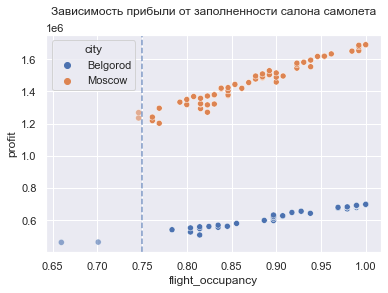

In [701]:
sns.scatterplot(y='profit', x='flight_occupancy', hue='city',
                data=data_for_analysis[data_for_analysis.flight_occupancy >= threshold_occupancy])
sns.scatterplot(y='profit', x='flight_occupancy', hue='city', alpha=0.6,
                data=data_for_analysis[data_for_analysis.flight_occupancy < threshold_occupancy], legend=False)
plt.title('Зависимость прибыли от заполненности салона самолета', pad=20)
plt.axvline(0.75, linestyle='--', alpha=0.7);
# plt.savefig('Зависимость прибыли от заполненности салона самолета.png', dpi=1200)

График зависимости прибыли от заполненности салона самолета для двух направлений хорошо показывает, что рейсы в Москву по заполняемости лежат почти на установленном нами пределе 75%. Поэтому по моему прогнозу стоит отказаться от рейсов 136642, 136807 в Белгород.

In [706]:
low_occupancy_flights[low_occupancy_flights.flight_id.isin([136642, 136807])]

,flight_id,city,city.1,longitude,latitude,longitude.1,latitude.1,flight_duration,model,fuel_cost,amount_sum,amount_count,seats_count_mean,flight_occupancy,profit
68,136642,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.816667,Sukhoi Superjet-100,67880.198167,531000.0,64,97,0.659794,463119
93,136807,Belgorod,Anapa,36.590099,50.643799,37.347301,45.002102,0.833333,Sukhoi Superjet-100,66119.431667,531000.0,68,97,0.701031,464880
